# Analyze seismic data

If not done already, install GraviLab (uncomment lines below)

In [1]:
#pip install gravilab

Imports

In [2]:
import gravilab as gl
from obspy import UTCDateTime

## Operations with time series

Open MINISEED data (.miniseed, .mseed, .msd file extensions) by specifying input folder or a single file. You can try to force opening files of other extension by specyfying `ignore_extension=True`, however in that case be careful as any non-seismic files in the folder, such as text files, will lead to a crash. 

Optionally you can specify channels in the file that you want to load and assign them names as in the example below.

This automatically creates a `Seismometer` object which holds corresponding time series. Seismic data is read with the help of [ObsPy package](https://docs.obspy.org/).

In [3]:
Seismometer1 = gl.open("seismic", channels = {"vertical":"HNZ","north":"HNY","east":"HNX"}, name="seismometer1")# first seismometer
Seismometer2 = gl.open("seismic", channels = {"vertical":"HHZ","north":"HHY","east":"HHX"}, name="seismometer2")# second seismometer

Reading data...
Done.
Reading data...
Done.


Time series corresponding to a system element are held in `SeismicTimeSeries` object, which can be accessed using `Seismometer.time_series` method. Time series data itself is held in a dictionary corresponding to a channel, and is accessed using `Seismometer.time_series[channel]`. Here is an example how to access and plot time series data for the "north" channel:

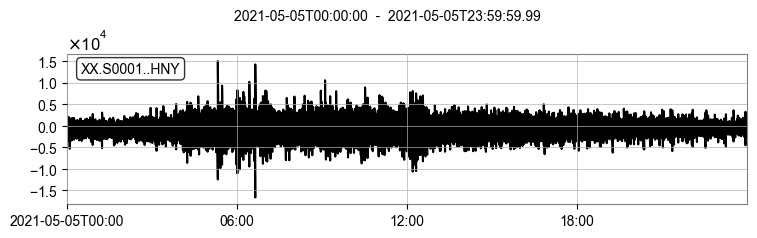

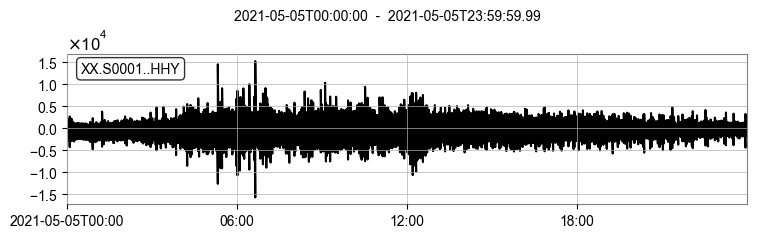

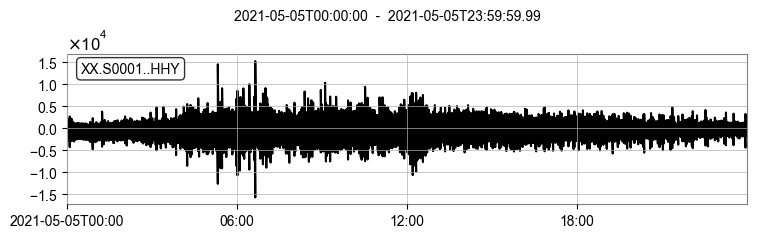

In [4]:
Seismometer1.time_series["north"].plot()
Seismometer2.time_series["north"].plot()

We can see above that these time series span one day, 5 of May 2021. One can create new `SeismicTimeSeries` object containing only a slice of that data using `SeismicTimeSeries.slice(..)`. Note this applies to all channels simultaneously.

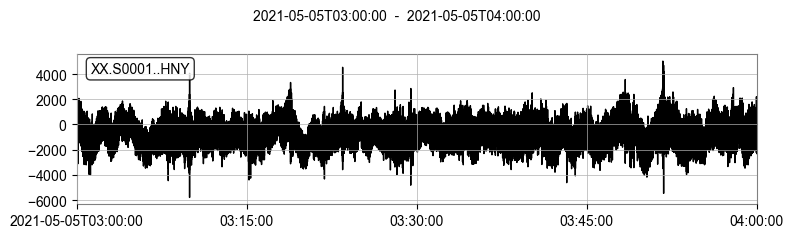

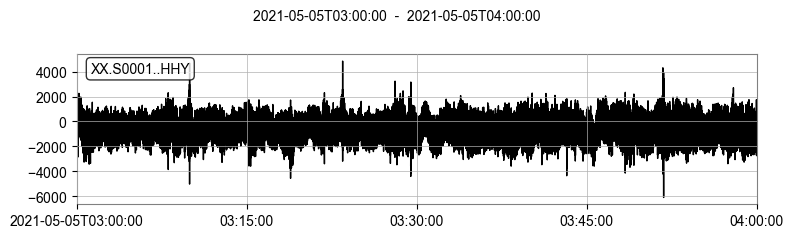

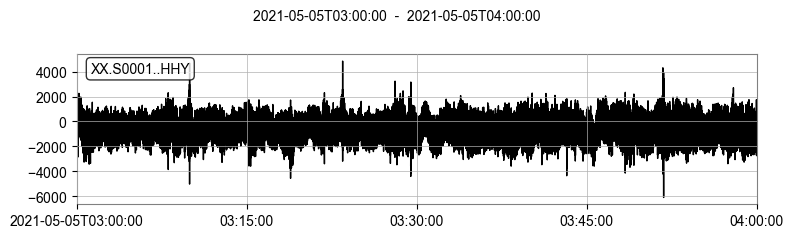

In [5]:
slice1 = Seismometer1.time_series.slice(UTCDateTime("2021-05-05T03:00:00"),UTCDateTime("2021-05-05T04:00:00"))
slice2 = Seismometer2.time_series.slice(UTCDateTime("2021-05-05T03:00:00"),UTCDateTime("2021-05-05T04:00:00"))
slice1["north"].plot()
slice2["north"].plot()

## Calculate PSD, ASD taking into account instrument response

Once we are happy with how time series look like, we can calculate spectra. For that first we should slice time series belonging to each `Seismometer` object:

In [6]:
Seismometer1 = Seismometer1.slice_time_series(UTCDateTime("2021-05-05T03:00:00"),UTCDateTime("2021-05-05T04:00:00"))
Seismometer2 = Seismometer2.slice_time_series(UTCDateTime("2021-05-05T03:00:00"),UTCDateTime("2021-05-05T04:00:00"))

Now we can also add instrument response transfer function. 

We can also change between units of velocity, acceleration and displacement by specifying appropriate `omega` factor.
In the example below, seismometer measures velocity but we want a displacement spectrum. 

In [7]:
response = {"poles" : [-0.036614 +0.037059j, -0.036614 -0.037059j, -32.55, -142, -364 +404j, -364 -404j, -1260, -4900 +5200j, -4900 -5200j, -7100 +1700j, -7100 -1700j],
            "zeros" : [0, 0, -31.63, -160, -350, -3177],
            "scale_factor" : 1202.5 * 8.31871e17 * 400000, #V/(m/s) times gain times counts/V
            "omega_exponent": -1, #convert from m/s to m
           }
Seismometer1.response = response
Seismometer2.response = response

Calculate ASD (we could also calculate PSD with `.psd` or use `.spectrum`, which defaults to ASD)

In [8]:
seismometer1_asd_north = Seismometer1.asd(method="lpsd")["north"]
seismometer2_asd_north = Seismometer2.asd(method="lpsd")["north"]

And plot

In [9]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,9)
plt.plot(seismometer1_asd_north,color='blue',label='seismometer 1, N-S')
plt.plot(seismometer2_asd_north,color='red',label='seismometer 1, N-S')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2, 1e2])
plt.ylim([1e-14, 1e-4])
plt.minorticks_on = True
plt.grid(which = 'both', axis = 'both')
plt.xlabel('frequency, Hz')
plt.ylabel('m/sqrt(Hz)')

Text(0, 0.5, 'm/sqrt(Hz)')

## Subtracting time series, residual spectrum

Time series can also be subtracted, which can be useful for example when calculating residual (noise) spectrum of two identical seismometers recording the same data.
Subtraction of time series is done simply with a "-" operator:

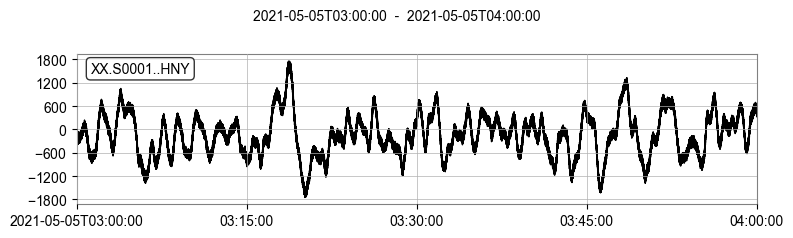

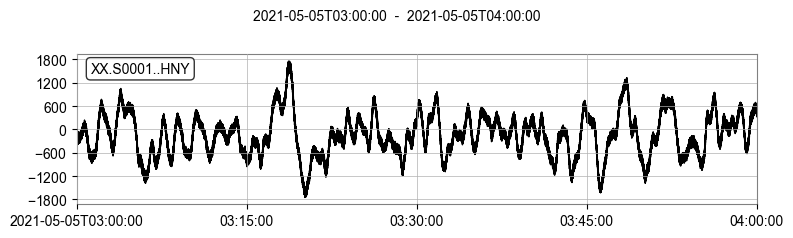

In [10]:
diff = slice1-slice2
diff["north"].plot()

Now lets create another Seismometer object and plot residual spectrum, actually this can be done in one line with time series subtraction

In [11]:
Seismometer_diff = gl.Seismometer(time_series = slice1 - slice2)
Seismometer_diff.response = response # note this only makes sense if input seismometers are identical and have identical response function

We can also calculate and plot spectrum of given type ("asd" in this case) in one line:

Text(0, 0.5, 'm/sqrt(Hz)')

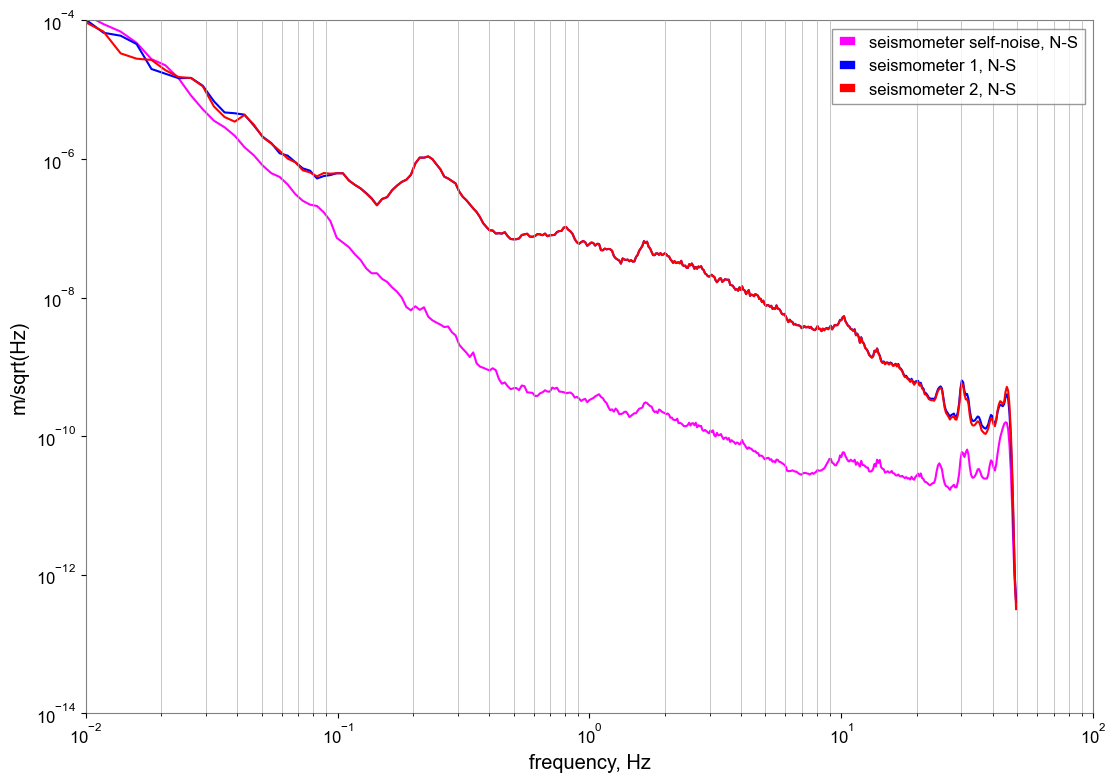

In [12]:
plt.plot(Seismometer_diff.spectrum("asd", method="lpsd")["north"],color='magenta',label='seismometer self-noise, N-S')
plt.plot(Seismometer1.spectrum("asd", method="lpsd")["north"],color='blue',label='seismometer 1, N-S')
plt.plot(Seismometer2.spectrum("asd", method="lpsd")["north"],color='red',label='seismometer 2, N-S')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2, 1e2])
plt.ylim([1e-14, 1e-4])
plt.minorticks_on = True
plt.grid(which = 'both', axis = 'both')
plt.xlabel('frequency, Hz')
plt.ylabel('m/sqrt(Hz)')

## Different averaging methods for spectra

The spectra above are logarithmic (L) power spectral density (LPSD) calculated with [lpsd package](https://gitlab.com/uhh-gwd/lpsd). Other options include default Welch method (no `method` keyword) and `daniell` method implemented in [GWpy](https://gwpy.github.io/docs/stable/index.html) and [Spicypy](https://gitlab.com/pyda-group/spicypy) packages, respectively (only Spicypy is used internally because it wraps around the other two methods)

C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'm/sqrt(Hz)')

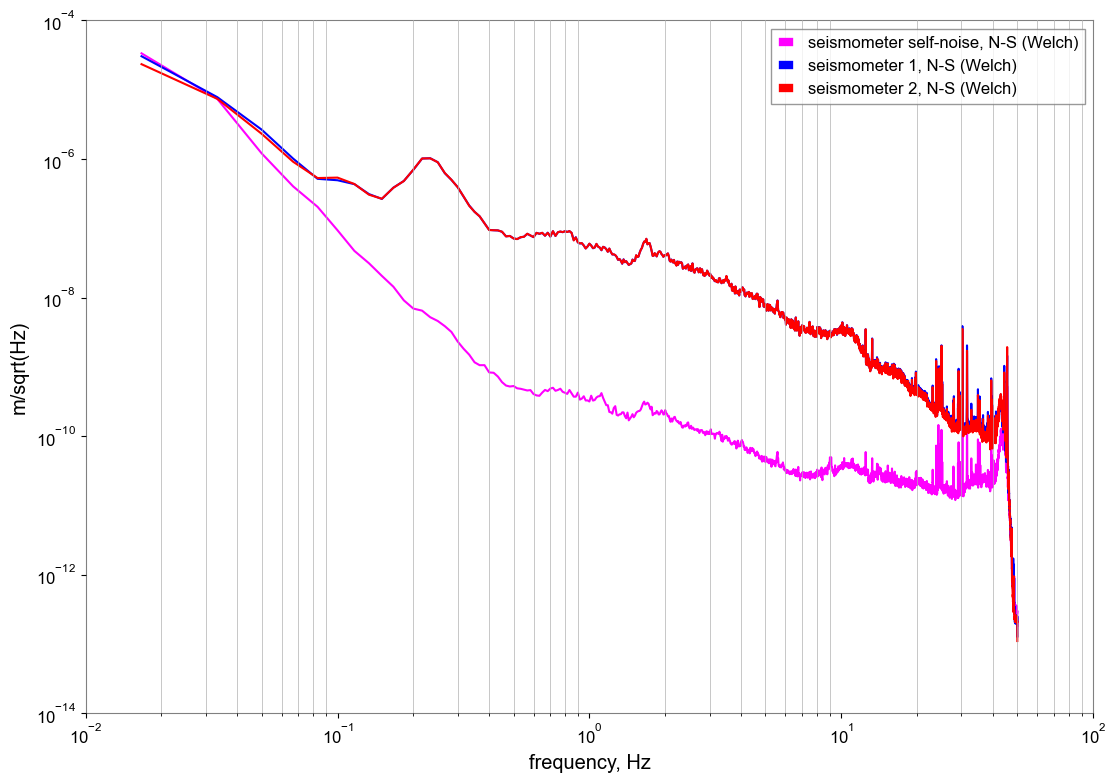

In [13]:
plt.plot(Seismometer_diff.spectrum("asd", fftlength=60)["north"],color='magenta',label='seismometer self-noise, N-S (Welch)')
plt.plot(Seismometer1.spectrum("asd", fftlength=60)["north"],color='blue',label='seismometer 1, N-S (Welch)')
plt.plot(Seismometer2.spectrum("asd", fftlength=60)["north"],color='red',label='seismometer 2, N-S (Welch)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2, 1e2])
plt.ylim([1e-14, 1e-4])
plt.minorticks_on = True
plt.grid(which = 'both', axis = 'both')
plt.xlabel('frequency, Hz')
plt.ylabel('m/sqrt(Hz)')

C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'm/sqrt(Hz)')

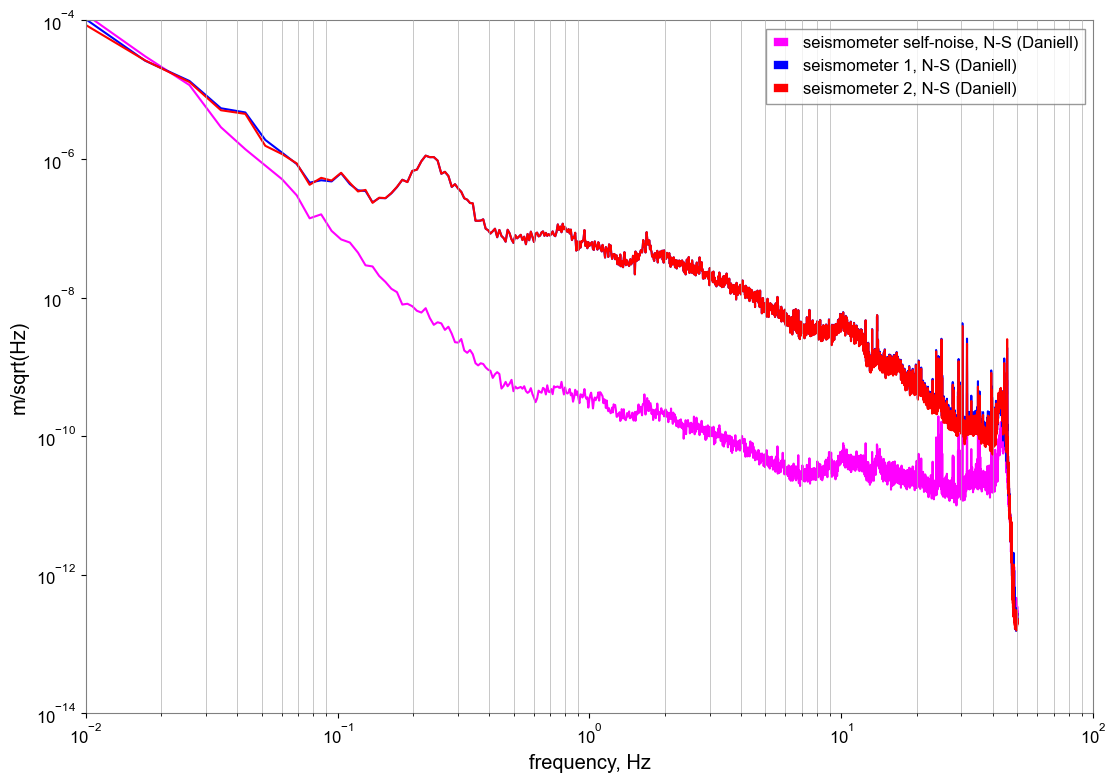

In [14]:
plt.plot(Seismometer_diff.spectrum("asd", method="daniell", number_averages=31)["north"],color='magenta',label='seismometer self-noise, N-S (Daniell)')
plt.plot(Seismometer1.spectrum("asd", method="daniell", number_averages=31)["north"],color='blue',label='seismometer 1, N-S (Daniell)')
plt.plot(Seismometer2.spectrum("asd", method="daniell", number_averages=31)["north"],color='red',label='seismometer 2, N-S (Daniell)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2, 1e2])
plt.ylim([1e-14, 1e-4])
plt.minorticks_on = True
plt.grid(which = 'both', axis = 'both')
plt.xlabel('frequency, Hz')
plt.ylabel('m/sqrt(Hz)')

## Interfacting with Spicypy

Gravilab already uses [Spicypy](https://gitlab.com/pyda-group/spicypy) package to calculate spectrum, as mentioned above. Associated data for every spectrum is `spicypy.FrequencySeries`, therefore all Spicypy methods can be used on it

In [15]:
print(Seismometer_diff.spectrum("asd", fftlength=60)["north"])

FrequencySeries([           nan, 3.33888192e-05, 7.32957045e-06,
                 ..., 2.91178406e-13, 2.92469023e-13,
                 1.82931795e-13]
                unit: 1 / Hz(1/2),
                f0: 0.0 Hz,
                df: 0.016666666666666666 Hz,
                epoch: 0.0,
                name: None,
                channel: north)


C:\Programfiles\Anaconda3-2020-07\envs\spicy_main\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


But `SeismicTimeSeries` can also be easily converted to `dict` of `spicypy.TimeSeries`

In [16]:
seism1_ts = Seismometer1.time_series.to_spicypy()["north"]
seism2_ts = Seismometer1.time_series.to_spicypy()["north"]
_ = seism1_ts.plot()
_ = seism1_ts.csd(seism2_ts, method="lpsd").plot()